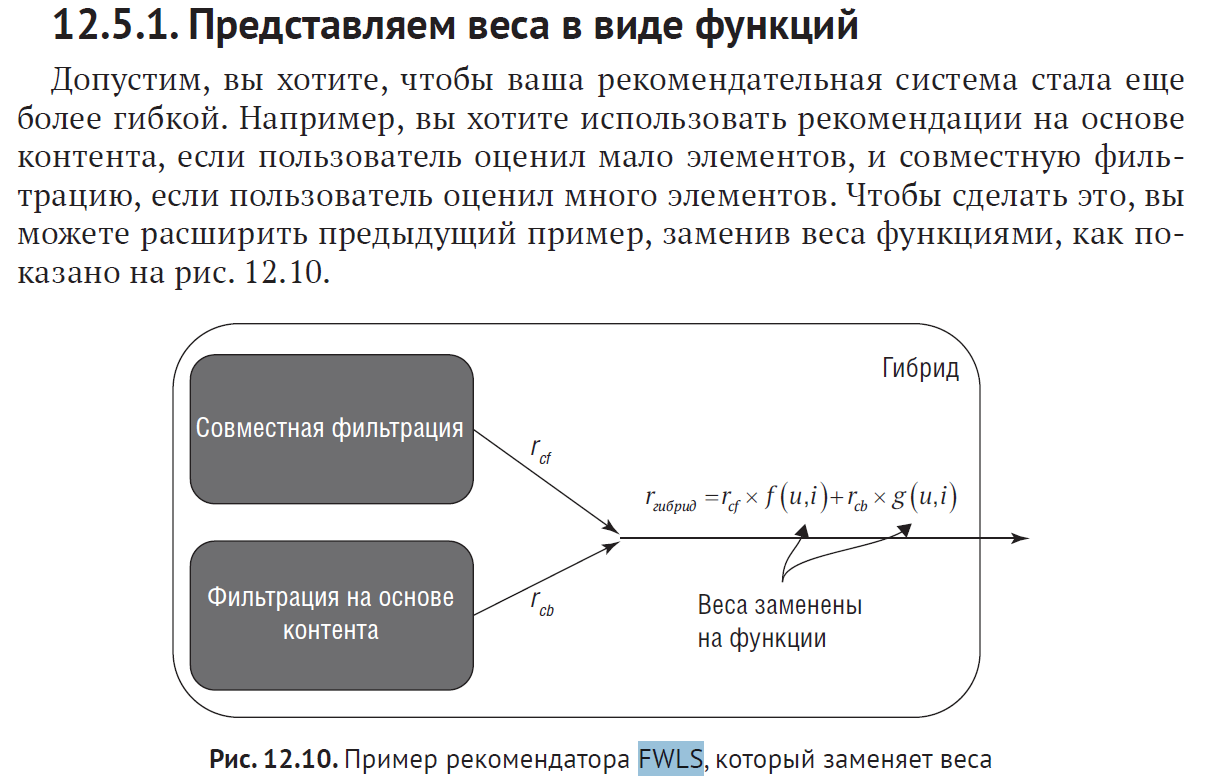

Контентная фильтрация
Совместная фильтрация элемент-элемент (косинусное расстояние)

In [1]:
import requests
import time
import pandas as pd
import numpy as np
from decimal import Decimal
from scipy.sparse import coo_matrix

# косинусовое сходство
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import linear_model

# import sys
# !{sys.executable} -m pip install stop_words
# !{sys.executable} -m pip install gensim
from stop_words import get_stop_words
import gensim
from nltk.tokenize import RegexpTokenizer
# tqdm показывает прогресс бар при выполнении итератора
from tqdm import tqdm
from datetime import datetime
from random import shuffle, randint, uniform

In [2]:
def get_user_ratings(users_ratings,user_id):
    return users_ratings[users_ratings['userId']==user_id]

In [3]:
## ТРЕБУЕТСЯ VPN!
def get_descriptions():

    url = """https://api.themoviedb.org/3/discover/movie?primary_release_date.gte={}&api_key={}&page={}"""
    api_key = "e100e79e22d8dfaff6602ce5611fa2d3"
    
    NUMBER_OF_PAGES = 501
    start_date = "1900-01-01"
    
    columns = ['movie_id', 'title', 'overview', 'genre_ids',  'release_date']
    M = pd.DataFrame([],columns=columns)

    for page in tqdm(range(1, NUMBER_OF_PAGES)):
        formated_url = url.format(start_date, api_key, page)
#         print(formated_url)
        r = requests.get(formated_url)
        for film in r.json()['results']:
            M.loc[M.shape[0]] = [film['id'],film['title'],film['overview'],film['genre_ids'],film['release_date']]
        
    return M

In [4]:
# получаем строки описаний
def content_recs_load_data():

    docs = get_descriptions()
    
    data = ["{}, {}, {}".format(row['title'], row['genre_ids'], row['overview']) for index, row in docs.iterrows()]

    if len(data) == 0:
        print("No descriptions were found")
    return data, docs

In [5]:
# data, docs = content_recs_load_data()

In [6]:
# docs.to_csv('movie_overviws_10000.csv', encoding='utf-8', index=False)

In [7]:
# print(docs.shape)

In [8]:
# получаем строки описаний
def content_recs_load_data_from_file():

    docs = pd.read_csv("movie_overviws_10000.csv")
    
    data = ["{}, {}, {}".format(row['title'], row['genre_ids'], row['overview']) for index, row in docs.iterrows()]

    if len(data) == 0:
        print("No descriptions were found")
    return data, docs

In [9]:
data, docs = content_recs_load_data_from_file()

In [10]:
print(docs)

      movie_id                           title  \
0       436270                      Black Adam   
1       724495                  The Woman King   
2      1013860  R.I.P.D. 2: Rise of the Damned   
3       736526                           Troll   
4      1049233                     Lesson Plan   
...        ...                             ...   
9995     11826                      Sexy Beast   
9996     16804                      Departures   
9997      6520                    First Knight   
9998    337676     Mektoub, My Love: Canto Uno   
9999      9270                           Brick   

                                               overview            genre_ids  \
0     Nearly 5,000 years after he was bestowed with ...        [28, 14, 878]   
1     The story of the Agojie, the all-female unit o...         [28, 18, 36]   
2     When Sheriff Roy Pulsipher finds himself in th...     [14, 28, 35, 80]   
3     Deep inside the mountain of Dovre, something g...         [14, 28, 12]   

In [11]:
def get_users_ratings():
    users_ratings = pd.read_csv("ratings.csv")
    users_ratings = users_ratings.drop('timestamp', axis=1)
    return users_ratings

In [12]:
users_ratings = get_users_ratings()

In [13]:
moviesCount = users_ratings['movieId'].unique().shape[0]
moviesCount

9724

In [14]:
docs = docs[:moviesCount]
docs.shape[0]

9724

In [15]:
data = data[:moviesCount]
len(data)

9724

In [16]:
#     Удаление не нужных слов (различные предлоги, вводные слова, общие слова)
def remove_stopwords(words):

#         так как текст на английском удаляем английский слова
        en_stop = get_stop_words('en')
# остаются только значимые слова (которые несут смысл)
        mean_words = [token for token in words if token not in en_stop]
        return mean_words

In [17]:
#     n_topics количество тем на которые разделяет документы LDA
def content_recs_build_lda_model(data, docs, n_topics=5):

        texts = []
#         разбиваем текст на слова
        tokenizer = RegexpTokenizer(r'\w+')
#     для каждого фильма формируется одна строка метаданных d 
        for d in tqdm(data):
#         преобразование строки к нижнему регистру
            raw = d.lower()
# разбиение строки на слова
            words = tokenizer.tokenize(raw)

            mean_words = remove_stopwords(words)

            stemmed_words = mean_words
            
#             можно также удалить окончание у слов, чтобы слова супергерой и супергеройский считались одинаковыми
            #stemmer = PorterStemmer()
            #stemmed_words = [stemmer.stem(token) for token in stopped_words]

            texts.append(stemmed_words)

        dictionary = gensim.corpora.Dictionary(texts)

        corpus = [dictionary.doc2bow(text) for text in texts]

        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,
                                                 num_topics=n_topics)

        index = gensim.similarities.MatrixSimilarity(corpus)


        return dictionary, texts, lda_model,index,corpus

In [20]:
dictionary, texts, lda_model,index,corpus = content_recs_build_lda_model(data,docs,20)

100%|███████████████████████████████████████████████████████████████████████████| 9724/9724 [00:00<00:00, 15013.55it/s]


In [42]:

docs_cashed_dict = {}
for i in range(docs.shape[0]):
    docs_cashed_dict[i]=docs.iloc[i]['movie_id']

436270

In [45]:
def content_recs_create_movie_similarity_df(index,docs):
    # получаем разряженную матрицу???
    coo = coo_matrix(index)
    # сжимаем её ??? (удаляем нулевые значения)
    csr = coo.tocsr()
    M = csr.toarray()
    print( np.where(M>0.3,1,0).sum())
    print(f'{coo.count_nonzero()} similarities to save')
    no_saved = 0
    min_sim=0.3
    start_time = datetime.now()
    xs, ys = coo.nonzero()
    
    
    columns = ['source_id', 'target_id', 'similarity']
    M = pd.DataFrame([],columns=columns)
    print(xs.shape)
    for x, y in tqdm(zip(xs, ys)):
    #     x это первый элемент кортежа, y второй; x,y это id строк описаний между которыми вычисляется сходство
#         print(x,y)
    # нет смысл сравнить строку описания с самой собой это вернёт 1 или близко к этому
        if x == y:
            continue

#         print(type(csr[x,y]))
        sim = csr[x, y]
    #     сходство строки описания x и y, такое же как и, y и x; что логично=)
#         if (float(csr[x, y]) != float(csr[y, x])):
#             print("Не печатается")
        x_id = docs_cashed_dict[x]
        y_id = docs_cashed_dict[y]
    #     Отбрасываем совсем непохожие элементы
        if sim < min_sim:
            continue

        M.loc[M.shape[0]] = [1,2,sim]
        no_saved += 1

    return M

In [46]:
# similarity_table = content_recs_create_movie_similarity_df(index,docs)

31294
62635868 similarities to save


11196it [00:00, 54574.93it/s]

(62635868,)


62635868it [20:59, 49716.50it/s]


In [47]:
# similarity_table.to_csv('similarity_table_FWLS.csv',index=False)

In [48]:
similarity_table = pd.read_csv("similarity_table_FWLS.csv")
print(similarity_table)

       source_id  target_id  similarity
0            1.0        2.0    0.305144
1            1.0        2.0    0.425628
2            1.0        2.0    0.423999
3            1.0        2.0    0.331970
4            1.0        2.0    0.360704
...          ...        ...         ...
21677        1.0        2.0    0.316228
21678        1.0        2.0    0.365148
21679        1.0        2.0    0.307729
21680        1.0        2.0    0.383065
21681        1.0        2.0    0.303822

[21682 rows x 3 columns]


In [49]:
current_user_id = 1

In [50]:
def get_content_recs(similarity_table,users_ratings,user_id,recs_number=30):
    user_ratings = get_user_ratings(users_ratings,user_id)
    user_mean = user_ratings['rating'].mean()

    user_ratings = user_ratings.sort_values(['rating'], ascending=[0])
    user_ratings.reset_index(drop=True, inplace=True)

    in_source=similarity_table['source_id'].isin(user_ratings['movieId']) 
    not_in_target=~similarity_table['target_id'].isin(user_ratings['movieId'])
#     print(similarity_table['source_id'].unique())
#     print(user_ratings['movie_id'].unique())
    top_by_sims = similarity_table.loc[in_source &  not_in_target].sort_values(['similarity'], ascending=[0])[:recs_number]
    top_by_sims.reset_index(drop=True, inplace=True)
#     print(top_by_sims)

    columns = ['target_id', 'prediction', 'sim_movies']
    recs = pd.DataFrame([],columns=columns)
    targets = top_by_sims['target_id'].unique()

    for target_row in targets:
        pre = 0
        sim_sum = 0
        rated_items = top_by_sims[top_by_sims['target_id']==target_row]
        if len(rated_items) > 0:
            for index, sim_item in rated_items.iterrows():
                user_rating = user_ratings[user_ratings['movieId']==sim_item['source_id']].iloc[0]['rating']

                r = user_rating- user_mean
                pre += sim_item.similarity * r
                sim_sum += sim_item.similarity
            if sim_sum > 0:
                recs.loc[recs.shape[0]] = [target_row,user_mean + pre/sim_sum,rated_items['source_id'].values]

    recs.sort_values(['prediction'], ascending=[0],inplace=True)
    recs = recs.astype({"target_id": int})
    recs.reset_index(drop=True, inplace=True)
    return recs

In [52]:
content_recs = get_content_recs(similarity_table,users_ratings,current_user_id)
content_recs 

,target_id,prediction,sim_movies
0,2,4.0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [53]:
def get_normalized_users_ratings(users_ratings):
    users_ratings = users_ratings.copy()
    
    mean_col = users_ratings.groupby(['userId'])['rating'].mean()
    max_col = users_ratings.groupby(['userId'])['rating'].max()
    min_col = users_ratings.groupby(['userId'])['rating'].min()

    for index, row in users_ratings.iterrows():
        users_ratings.at[index,'mean']=(row['rating']-mean_col.at[row['userId']])/(max_col.at[row['userId']]-min_col.at[row['userId']])

    return users_ratings

In [54]:
def create_categories(users_ratings):
    users_ratings = get_normalized_users_ratings(users_ratings)
    
    users_values = users_ratings['userId'].sort_values().unique()
    movies_values = users_ratings['movieId'].sort_values().unique()
    
    user_categories = dict(enumerate(users_ratings['userId'].sort_values().unique()))
    movie_categories = dict(enumerate(users_ratings['movieId'].sort_values().unique()))
    
    for index, row in users_ratings.iterrows():
        users_ratings.at[index,'movieId'] = np.where(movies_values == row['movieId'])[0]
        users_ratings.at[index,'userId'] = np.where(users_values == row['userId'])[0]

    return users_ratings,user_categories,movie_categories

In [55]:
users_ratings_categorized,user_categories,movie_categories = create_categories(users_ratings)

<ipython-input-53-b255f66f47c0>:9: RuntimeWarning: invalid value encountered in double_scalars
  users_ratings.at[index,'mean']=(row['rating']-mean_col.at[row['userId']])/(max_col.at[row['userId']]-min_col.at[row['userId']])


In [56]:
def create_overlap_matrix(users_ratings_categorized,min_overlap=4):
    coo = coo_matrix((users_ratings_categorized['mean'],(users_ratings_categorized['movieId'],users_ratings_categorized['userId'])))
    overlap_matrix = coo.astype(bool).astype(int).dot(coo.transpose().astype(bool).astype(int))
    number_of_overlaps = (overlap_matrix > min_overlap).count_nonzero()
    
    return coo,overlap_matrix, number_of_overlaps

In [57]:
coo,overlap_matrix, number_of_overlaps = create_overlap_matrix(users_ratings_categorized)

In [81]:
coo = coo_matrix(np.nan_to_num(coo.toarray()))
print(np.isnan(coo.toarray()).any())


False


In [82]:
def get_similarity_matrix(coo,overlap_matrix,min_overlap=4,min_sim=0.3):
    # Вычисляем сходство
    cor = cosine_similarity(coo, dense_output=False)
    cor = np.nan_to_num(cor)
    # Отбрасываем элементы с низким сходством (-1 фильмы совершенно непохожи, 1 фильмы одинаковы)
    cor = cor.multiply(cor > min_sim)
    cor = cor.multiply(overlap_matrix > min_overlap)
    return cor

In [83]:
cor = get_similarity_matrix(coo,overlap_matrix)

In [86]:
def save_sims_item_item(cor,movies_categories, min_sim=0.2):
    print(np.where(cor.toarray()>min_sim,1,0).sum())
    coo = coo_matrix(cor)
#     print(coo)
    csr = coo.tocsr()
    
    no_saved = 0
   
    xs, ys = coo.nonzero()

    columns = ['source_id', 'target_id', 'similarity']
    M = pd.DataFrame([],columns=columns)
    
    print(xs.shape)
    for x, y in tqdm(zip(xs, ys)):
    #     x это первый элемент кортежа, y второй; x,y это id строк описаний между которыми вычисляется сходство
#         print(x,y)
    # нет смысл сравнить строку описания с самой собой это вернёт 1 или близко к этому
        if x == y:
            continue
        sim = csr[x, y]
        if sim < min_sim:
            continue
        M.loc[M.shape[0]] = [int(movies_categories[x]),int(movies_categories[y]),sim]
       
        no_saved += 1
   
    M['source_id'] =  M['source_id'].astype(int)
    M['target_id'] =  M['target_id'].astype(int)
    return M

In [87]:
# similarity_table_cosine_item_item = save_sims_item_item(cor,movie_categories)

403it [00:00, 1948.79it/s]

19684
(19684,)


19684it [00:14, 1400.05it/s]


In [88]:
# similarity_table_cosine_item_item.to_csv('similarity_table_FWLS_item_cos.csv',index=False)

In [92]:
similarity_table_item_item = pd.read_csv('similarity_table_FWLS_item_cos.csv')
print(similarity_table_item_item)

       source_id  target_id  similarity
0              1       3114    0.351655
1              3       1461    0.318994
2              3       2133    0.301293
3              3       3450    0.304456
4              4        371    0.508251
...          ...        ...         ...
16031     180031     122882    0.370263
16032     180031     122926    0.564136
16033     180031     168252    0.319365
16034     187593     122912    0.628535
16035     187595     122926    0.393997

[16036 rows x 3 columns]


In [93]:
def get_item_item_recs(similarity_table,users_ratings,user_id,recs_number=30):
    current_user_ratings = get_user_ratings(users_ratings,user_id)
    current_user_mean = current_user_ratings['rating'].mean()

    # сортируем оценки по самым высоким
    current_user_ratings=current_user_ratings.sort_values(['rating'], ascending=[0])
    current_user_ratings.reset_index(drop=True, inplace=True)

    # получаем только те фильмы которые оцнены текущим пользователем и находятся в таблице сходств
    in_source=similarity_table['source_id'].isin(current_user_ratings['movieId']) 
    # Исключаем из таблице сходств уже оцененные фильмы пользователи (не нужно рекомендовать, то, что уже было просмотренно)
    not_in_target=~similarity_table['target_id'].isin(current_user_ratings['movieId'])

    # Получаем таблиц сходств для текущего пользователя
    top_by_sims = similarity_table.loc[in_source &  not_in_target].sort_values(['similarity'], ascending=[0])[:recs_number]
    top_by_sims.reset_index(drop=True, inplace=True)

    columns = ['target_id', 'prediction', 'sim_movies']
    recs = pd.DataFrame([],columns=columns)
    targets = top_by_sims['target_id'].unique()

    for target_row in targets:
        pre = 0
        sim_sum = 0
        rated_items = top_by_sims[top_by_sims['target_id']==target_row]
        if len(rated_items) > 0:
            for index, sim_item in rated_items.iterrows():
    #             получаем оценку пользователя для фильма
                user_rating = current_user_ratings[current_user_ratings['movieId']==sim_item['source_id']].iloc[0]['rating']
    #         вычитаем из оценки среднюю для пользователя
                r = user_rating- current_user_mean
    #     умножаем схожесть на оценку
                pre += sim_item.similarity * r
                sim_sum += sim_item.similarity
            if sim_sum > 0:
    # формируем прогноз
                recs.loc[recs.shape[0]] = [target_row,current_user_mean + pre/sim_sum,rated_items['source_id'].values]
        
    recs.sort_values(['prediction'], ascending=[0],inplace=True)
    recs = recs.astype({"target_id": int})
    recs.reset_index(drop=True, inplace=True)
    return recs

In [94]:
item_item_recs = get_item_item_recs(similarity_table_item_item,users_ratings,current_user_id)
item_item_recs

,target_id,prediction,sim_movies
0,2539,5.000000,[3450]
1,4366,5.000000,[2048]
2,2989,5.000000,"[2993, 2991]"
3,1221,5.000000,[1213]
4,3060,5.000000,[1298]
5,589,5.000000,[1240]
6,3270,5.000000,[2470]
7,858,5.000000,[1213]
8,3614,5.000000,[2991]
9,7247,5.000000,[1031]


In [96]:
# получаем рекомендации от контентной фильтрации
content_recs = get_content_recs(similarity_table,users_ratings,current_user_id)

# получаем рекомендации от совместной рекомендации элемент-элемент
item_item_recs = get_item_item_recs(similarity_table_item_item,users_ratings,current_user_id)

In [97]:
# step 1
# получение оценок всех пользователей
all_ratings = users_ratings

# разбиение выборок на тетсовую и обучающую
train_data, test_data = train_test_split(all_ratings, test_size=0.2)

In [98]:
def get_content_prediction(similarity_table,users_ratings,user_id,movie_id):
    user_ratings = get_user_ratings(users_ratings,user_id)
    user_mean = user_ratings['rating'].mean()

    user_ratings = user_ratings.sort_values(['rating'], ascending=[0])
    user_ratings.reset_index(drop=True, inplace=True)

    in_source=similarity_table['source_id'].isin(user_ratings['movieId']) 
    in_target=similarity_table['target_id']==movie_id
    not_in_source=similarity_table['source_id']!=movie_id

    top_by_sims = similarity_table.loc[in_source &  not_in_source & in_target].sort_values(['similarity'], ascending=[0])[:30]
    top_by_sims.reset_index(drop=True, inplace=True)

    
    pre = 0
    sim_sum = 0
#     print(target_row)
    rated_items = top_by_sims[top_by_sims['target_id']==movie_id]
#     print(rated_items)
    if len(rated_items) > 0:
        for index, sim_item in rated_items.iterrows():
            user_rating = user_ratings[user_ratings['movieId']==sim_item['source_id']].iloc[0]['rating']

            r = user_rating- user_mean
            pre += sim_item.similarity * r
            sim_sum += sim_item.similarity
        return user_mean + pre/sim_sum


    return user_mean

In [99]:
def get_item_item_prediction(similarity_table,users_ratings,user_id,movie_id):
    current_user_ratings = get_user_ratings(users_ratings,user_id)
    current_user_mean = current_user_ratings['rating'].mean()

    # сортируем оценки по самым высоким
    current_user_ratings=current_user_ratings.sort_values(['rating'], ascending=[0])
    current_user_ratings.reset_index(drop=True, inplace=True)

    # получаем только те фильмы которые оцнены текущим пользователем и находятся в таблице сходств
    in_source=similarity_table['source_id'].isin(current_user_ratings['movieId']) 
    # Исключаем из таблице сходств уже оцененные фильмы пользователи (не нужно рекомендовать, то, что уже было просмотренно)
    not_in_source=similarity_table['source_id'] != movie_id
    in_target=similarity_table['target_id'] == movie_id

    # Получаем таблиц сходств для текущего пользователя
    top_by_sims = similarity_table.loc[in_source & not_in_source & in_target].sort_values(['similarity'], ascending=[0])[:30]
    top_by_sims.reset_index(drop=True, inplace=True)

    columns = ['target_id', 'prediction', 'sim_movies']
    recs = pd.DataFrame([],columns=columns)
    targets = top_by_sims['target_id'].unique()

    
    
#     for target_row in targets:
    pre = 0
    sim_sum = 0
    rated_items = top_by_sims[top_by_sims['target_id']==movie_id]
    if len(rated_items) > 0:
        for index, sim_item in rated_items.iterrows():
#             получаем оценку пользователя для фильма
            user_rating = current_user_ratings[current_user_ratings['movieId']==sim_item['source_id']].iloc[0]['rating']
#         вычитаем из оценки среднюю для пользователя
            r = user_rating- current_user_mean
#     умножаем схожесть на оценку
            pre += sim_item.similarity * r
            sim_sum += sim_item.similarity
        return current_user_mean + pre/sim_sum
        
    return current_user_mean

In [101]:
movie_id = 2
print(get_content_prediction(similarity_table,train_data,current_user_id,movie_id))
print(get_item_item_prediction(similarity_table_item_item,train_data,current_user_id,movie_id))

4.0
4.357142857142857


In [105]:
tqdm.pandas()
train_data['cb'] = train_data.progress_apply(lambda data: get_content_prediction(similarity_table,train_data,data['userId'], data['movieId']), axis='columns', result_type='expand')
train_data['iib'] = train_data.progress_apply(lambda data: get_item_item_prediction(similarity_table_item_item,train_data,data['userId'], data['movieId']), axis='columns', result_type='expand')

100%|███████████████████████████████████████████████████████████████████████████| 80668/80668 [03:05<00:00, 434.89it/s]
<ipython-input-105-fb8e2ed26753>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cb'] = train_data.progress_apply(lambda data: get_content_prediction(similarity_table,train_data,data['userId'], data['movieId']), axis='columns', result_type='expand')
100%|███████████████████████████████████████████████████████████████████████████| 80668/80668 [04:58<00:00, 270.07it/s]
<ipython-input-105-fb8e2ed26753>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [125]:
def fun1():
    return 1.0

# Если пользователь оценил менее 5 фильмов вернуть 1 иначе 0
def fun2(all_ratings,user_id):
    user_ratings = all_ratings['userId']==user_id
    rating_count = all_ratings[user_ratings].shape[0]
#     print(rating_count)
    if rating_count < 100:
        return 1.0
    return 0.0

In [126]:
# all_ratings[all_ratings['userId']==2].shape[0]

In [127]:
def calculate_feature_functions_for_training_data(train_data,func1,func2):
    train_data['cb1'] = train_data.progress_apply(lambda data:data.cb*func1(), axis='columns', result_type='expand')
    train_data['cb2'] = train_data.progress_apply(lambda data:data.cb*func2(train_data,data['userId']), axis='columns', result_type='expand')
    train_data['iib1'] = train_data.progress_apply(lambda data:data.iib*func1(), axis='columns', result_type='expand')
    train_data['iib2'] = train_data.progress_apply(lambda data:data.iib*func2(train_data,data['userId']), axis='columns', result_type='expand')
    
calculate_feature_functions_for_training_data(train_data, fun1,fun2)

100%|████████████████████████████████████████████████████████████████████████| 80668/80668 [00:00<00:00, 124048.72it/s]
<ipython-input-127-95f4de4f1570>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cb1'] = train_data.progress_apply(lambda data:data.cb*func1(), axis='columns', result_type='expand')
100%|██████████████████████████████████████████████████████████████████████████| 80668/80668 [00:41<00:00, 1962.89it/s]
<ipython-input-127-95f4de4f1570>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

In [128]:
def train(train_data):

    regr = linear_model.LinearRegression(fit_intercept=True,
                                         n_jobs=-1,
                                         normalize=True)

    regr.fit(train_data[['cb1', 'cb2', 'iib1', 'iib2']], train_data['rating'])

    result = {'cb1': regr.coef_[0],
              'cb2': regr.coef_[1],
              'iib1': regr.coef_[2],
              'iib2': regr.coef_[3],
              'intercept': regr.intercept_}

    
    return result

In [129]:
# w_coefs = train(train_data)


In [131]:
w_coefs = {'cb1': 0.2279104636514928, 'cb2': 0.02453262228519541, 'iib1': 0.7826217343302062, 'iib2': -0.02803987847803048, 'intercept': -0.06620750604235859}

In [132]:
print(w_coefs)

{'cb1': 0.2279104636514928, 'cb2': 0.02453262228519541, 'iib1': 0.7826217343302062, 'iib2': -0.02803987847803048, 'intercept': -0.06620750604235859}


In [143]:
def prediction(p_cb, p_iib, train_data,user_id,w_coefs):
    intercept = 0
    p = (w_coefs['cb1'] * fun1() * p_cb + w_coefs['cb2'] * fun2(train_data,user_id) * p_cb +
    w_coefs['iib1'] * fun1() * p_iib +w_coefs['iib2'] * fun2(train_data,user_id) * p_iib)
    print(p + w_coefs['intercept'])
    return p + w_coefs['intercept']

In [138]:
def recommend_items(all_users_ratings,users_ratings,user_id,similarity_table_content,similarity_table_item_item,w_coefs, num=10):
    cb_recs = get_content_recs(similarity_table_content,users_ratings,user_id, num * 5)
    jb_recs = get_item_item_recs(similarity_table_item_item,users_ratings,user_id, num * 5)
    combined_recs = dict()
    
    for index,rec in cb_recs.iterrows():
        movie_id = rec[0]
        pred = rec[1]
        combined_recs[movie_id] = {'cb': pred}
        
    for index,rec in jb_recs.iterrows():
        movie_id = rec[0]
        pred = rec[1]
        if movie_id in combined_recs.keys():
            combined_recs[movie_id]['iib'] = pred
        else:
            combined_recs[movie_id] = {'iib': pred}
    
    columns = ['target_id', 'prediction']
    fwls_preds = pd.DataFrame([],columns=columns)
    for key, recs in combined_recs.items():
        if 'cb' not in recs.keys():
            recs['cb'] = get_content_prediction(similarity_table_content,users_ratings,user_id, key)
        if 'iib' not in recs.keys():
            recs['iib'] = get_item_item_prediction(similarity_table_item_item,users_ratings,user_id, key)
        pred = prediction(recs['cb'], recs['iib'],all_users_ratings, user_id,w_coefs)
        fwls_preds.loc[fwls_preds.shape[0]]=[key,pred]


    fwls_preds.sort_values(['prediction'], ascending=[0],inplace=True)
    fwls_preds = fwls_preds.astype({"target_id": int})
    fwls_preds.reset_index(drop=True, inplace=True)
    return fwls_preds[:num]

In [144]:
recs_FWLS = recommend_items(train_data,users_ratings,current_user_id,similarity_table,similarity_table_item_item,w_coefs)

4.262657697169211
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.842044698707648
4.465867235629059
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
4.0594229643774415
3.2768012300472353
3.2768012300472353
3.2768012300472353
3.2768012300472353
3.2768012300472353
3.2768012300472353
3.2768012300472353
3.2768012300472353
3.2768012300472353


In [145]:
print(recs_FWLS)

   target_id  prediction
0        594    4.842045
1       7247    4.842045
2       3635    4.842045
3        858    4.842045
4       3197    4.842045
5       2407    4.842045
6       3022    4.842045
7       2989    4.842045
8       3614    4.842045
9       1221    4.842045


In [141]:
print(content_recs)

   target_id  prediction                                         sim_movies
0          2         4.0  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...


In [142]:
print(item_item_recs)

    target_id  prediction    sim_movies
0        2539    5.000000        [3450]
1        4366    5.000000        [2048]
2        2989    5.000000  [2993, 2991]
3        1221    5.000000        [1213]
4        3060    5.000000        [1298]
5         589    5.000000        [1240]
6        3270    5.000000        [2470]
7         858    5.000000        [1213]
8        3614    5.000000        [2991]
9        7247    5.000000        [1031]
10        594    5.000000         [596]
11       3635    5.000000        [2948]
12       3197    5.000000        [1298]
13      44972    5.000000        [3273]
14       3984    4.519337  [2991, 3639]
15       2334    4.000000        [3440]
16       1616    4.000000        [1620]
17       1200    4.000000        [1214]
18       5585    4.000000        [3439]
19       2405    4.000000        [2616]
20       2011    4.000000        [2012]
21       4467    4.000000        [1967]
22       1021    3.000000        [3243]
23       1390    3.000000        [3243]
